Label classes: ['anger' 'fear' 'love' 'sadness']


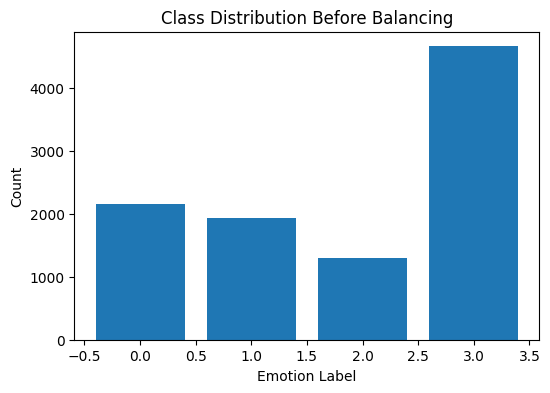

Vocab size: 11453


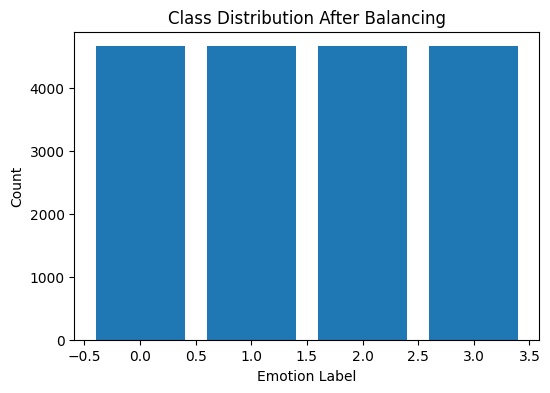

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 187s 426ms/step - accuracy: 0.3642 - loss: 1.4880 - val_accuracy: 0.8608 - val_loss: 0.4676
Epoch 2/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 195s 410ms/step - accuracy: 0.9379 - loss: 0.2156 - val_accuracy: 0.8481 - val_loss: 0.4552
Epoch 3/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 176s 418ms/step - accuracy: 0.9717 - loss: 0.1069 - val_accuracy: 0.9545 - val_loss: 0.1848
Epoch 4/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 198s 409ms/step - accuracy: 0.9806 - loss: 0.0734 - val_accuracy: 0.9632 - val_loss: 0.1706
Epoch 5/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 172s 410ms/step - accuracy: 0.9825 - loss: 0.0579 - val_accuracy: 0.9418 - val_loss: 0.2490
Epoch 6/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 171s 407ms/step - accuracy: 0.9829 - loss: 0.0548 - val_accuracy: 0.9578 - val_loss: 0.1572
Epoch 7/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 203s 408ms/step - accuracy: 0.9866 - loss: 0.0518 - val_accuracy: 0.9605 - val_loss: 0.1732
Epoch 8/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 201s 405ms/step - accuracy: 0.9896 -

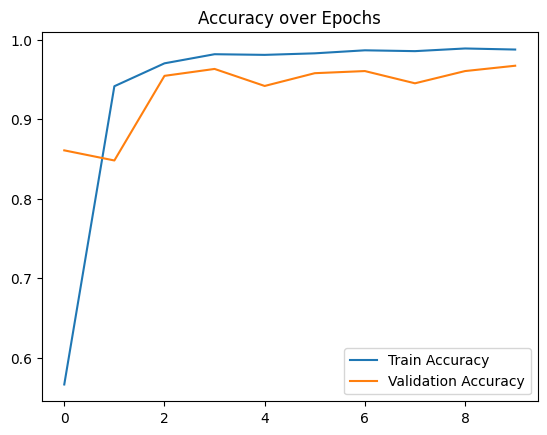

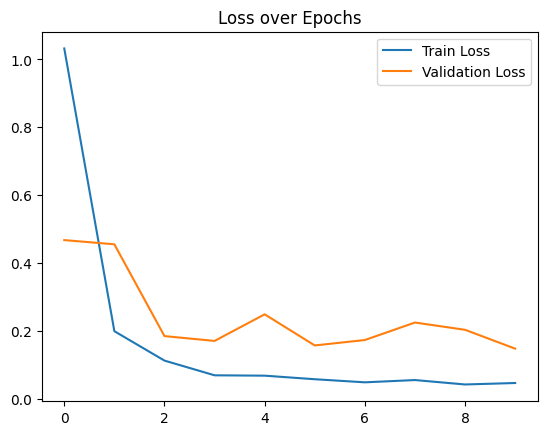

['label_encoder.jb']

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam

from imblearn.over_sampling import RandomOverSampler
import joblib

# Load dataset
data = pd.read_csv("emotion_dataset.csv")

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www\S+", "", text)
    text = re.sub(r"@\w+", "", text)  # fixed regex
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply preprocessing
data["text"] = data["text"].astype(str).apply(preprocess_text)

# Label encoding
label_encoder = LabelEncoder()
data["label"] = label_encoder.fit_transform(data["label"])
print("Label classes:", label_encoder.classes_)  # Debugging aid

# Plot class distribution before balancing
plt.figure(figsize=(6, 4))
plt.bar(Counter(data["label"]).keys(), Counter(data["label"]).values())
plt.title("Class Distribution Before Balancing")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.show()

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data["text"])
vocab_size = len(tokenizer.word_index) + 1
print("Vocab size:", vocab_size)

max_length = 100
x = tokenizer.texts_to_sequences(data["text"])
x = pad_sequences(x, maxlen=max_length, padding="post")
y = data["label"].values

# Balance the data
ros = RandomOverSampler(random_state=42)
x_resampled, y_resampled = ros.fit_resample(x, y)

# Plot class distribution after balancing
plt.figure(figsize=(6, 4))
plt.bar(Counter(y_resampled).keys(), Counter(y_resampled).values())
plt.title("Class Distribution After Balancing")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.show()

# Split the data
x_train, x_test, y_train, y_test = train_test_split(
    x_resampled, y_resampled, test_size=0.2, random_state=42
)

# Model definition
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=200, input_length=max_length),
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation="relu"),
    BatchNormalization(),
    Dense(len(np.unique(y_resampled)), activation="softmax")
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training history
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss over Epochs")
plt.show()

# Save model and artifacts
model.save("emotion_model.h5")
joblib.dump(tokenizer, "tokenizer.jb")
joblib.dump(label_encoder, "label_encoder.jb")
